In [1]:
######### Package Imports #########################################################################
import os, warnings, copy, torch, ax
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement
from ax.modelbridge.transforms.standardize_y import StandardizeY
from ax.modelbridge.transforms.unit_x import UnitX
from ax.modelbridge.transforms.remove_fixed import RemoveFixed
from ax.modelbridge.transforms.log import Log
from ax.core.base_trial import TrialStatus as T
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.slice import plot_slice

from optimpv import *
from optimpv.axBOtorch.axBOtorchOptimizer import axBOtorchOptimizer
from optimpv.RateEqfits.RateEqAgent import RateEqAgent
from optimpv.RateEqfits.RateEqModel import *
from optimpv.RateEqfits.Pumps import *

init_notebook_plotting()
warnings.filterwarnings('ignore') 
##############################################################################################
# Define the parameters to be fitted
params = []

k_direct = FitParam(name = 'k_direct', value = 3.9e-17, bounds = [1e-18,1e-16], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$k_{\text{direct}}$', unit='m$^{3}$ s$^{-1}$', axis_type = 'log')
params.append(k_direct)

k_trap = FitParam(name = 'k_trap', value = 4e-18, bounds = [1e-19,1e-17], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$k_{\text{trap}}$', unit='m$^{3}$ s$^{-1}$', axis_type = 'log')
params.append(k_trap)

k_detrap = FitParam(name = 'k_detrap', value = 3.1e-18, bounds = [1e-19,1e-17], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$k_{\text{detrap}}$', unit='s$^{-1}$', axis_type = 'log')
params.append(k_detrap)

N_t_bulk = FitParam(name = 'N_t_bulk', value = 1.6e23, bounds = [1e22,5e23], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$N_{\text{t,bulk}}$', unit='m$^{-3}$', axis_type = 'log')
params.append(N_t_bulk)

I_factor = FitParam(name = 'I_factor_PL', value = 1e-32, bounds = [1e-33,1e-31], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$I_{\text{PL}}$', unit='-', axis_type = 'log')
params.append(I_factor)

I_factor = FitParam(name = 'I_factor_MC', value = 2.2e-26, bounds = [1e-27,1e-25], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$I_{\text{PL}}$', unit='-', axis_type = 'log')
params.append(I_factor)

ratio_mu = FitParam(name = 'ratio_mu', value = 4.2, bounds = [1,10], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$\mu_{\text{ratio}}$', unit='-', axis_type = 'linear')
params.append(ratio_mu)

# original values
params_orig = copy.deepcopy(params)
dum_dic = {}
for i in range(len(params)):
    dum_dic[params[i].name] = params[i].value/params[i].fscale # we need this just to run the model to generate some fake data

[INFO 12-10 16:02:54] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 12-10 16:02:54] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


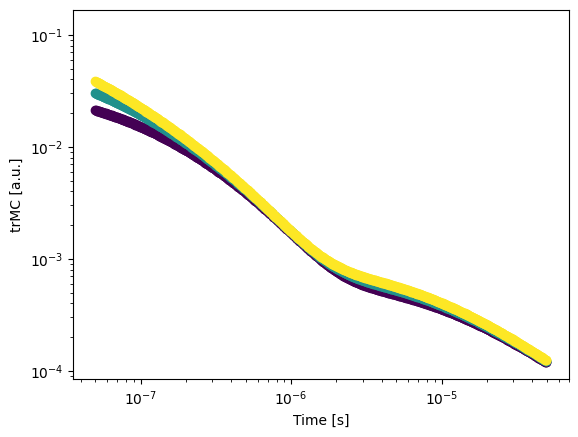

In [2]:
# trMC model
fpu = 1e3
N0 = 1.041e24
background = 0

t = np.geomspace(5e-8, 1/fpu, 1000)
# add 0 to the time array
t = np.insert(t, 0, 0)
# remove the last element
t = t[:-1]
# remove t > 1e-4
t = t[t<=5e-5]

Gfracs = [1, 0.552, 0.290]
# concatenate the time and Gfracs
X = None
for Gfrac in Gfracs:
    if X is None:
        X = np.array([t,Gfrac*np.ones(len(t))]).T
    else:
        X = np.concatenate((X,np.array([t,Gfrac*np.ones(len(t))]).T),axis=0) 

y_ = X # dummy data

# Define the agents
metric = 'mse'
loss = 'soft_l1'
threshold = 1
exp_format = 'trMC'
pump_args = {'N0': N0, 'fpu': fpu , 'background' : background, }

RateEq_fake = RateEqAgent(params, [X], [y_], model = BTD_model, pump_model = initial_carrier_density, pump_args = pump_args, fixed_model_args = {}, metric = metric, loss = loss, threshold=threshold,minimize=True,exp_format=exp_format,compare_logs=True,detection_limit=5e-5)

y_MC = RateEq_fake.run(dum_dic,exp_format=exp_format)

plt.figure()
viridis = plt.cm.get_cmap('viridis', len(Gfracs))
for idx, Gfrac in enumerate(Gfracs):
    plt.plot(X[X[:,1]==Gfrac,0], y_MC[X[:,1]==Gfrac],'o',label=str(Gfrac), color=viridis(idx))
    # plt.plot(t, y_[X[:,1]==Gfrac],label=str(Gfrac)+'_', color=viridis(Gfrac), linestyle='--')
# plt.plot(X[:,0], y,'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel(exp_format + ' [a.u.]')
plt.show()


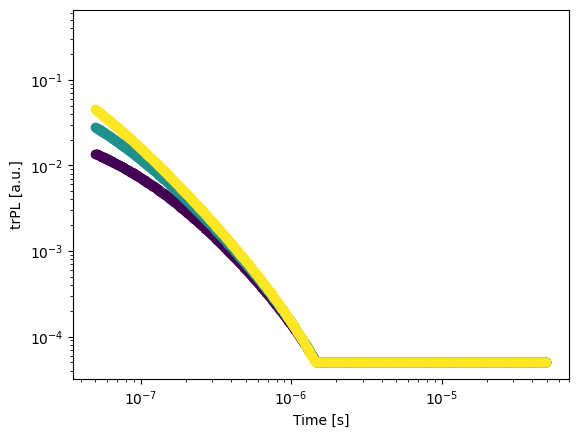

In [3]:
# trPL model
metric = 'mse'
loss = 'soft_l1'
threshold = 1
exp_format = 'trPL'

pump_args = {'N0': N0, 'fpu': fpu , 'background' : background, }

RateEq_fake = RateEqAgent(params, [X], [y_], model = BTD_model, pump_model = initial_carrier_density, pump_args = pump_args, fixed_model_args = {}, metric = metric, loss = loss, threshold=threshold,minimize=True,exp_format=exp_format,compare_logs=True,detection_limit=5e-5)

y_PL = RateEq_fake.run(dum_dic,exp_format=exp_format)

plt.figure()
viridis = plt.cm.get_cmap('viridis', len(Gfracs))
for idx, Gfrac in enumerate(Gfracs):
    plt.plot(X[X[:,1]==Gfrac,0], y_PL[X[:,1]==Gfrac],'o',label=str(Gfrac), color=viridis(idx))
    # plt.plot(t, y_[X[:,1]==Gfrac],label=str(Gfrac)+'_', color=viridis(Gfrac), linestyle='--')
# plt.plot(X[:,0], y,'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
# plt.ylim([1e-5,1])
plt.ylabel(exp_format + ' [a.u.]')
plt.show()

In [4]:
metric = 'mse'
loss = 'soft_l1'
threshold = 1

RateEq = RateEqAgent(params, [X,X], [y_PL,y_MC], model = BTD_model, pump_model = initial_carrier_density, pump_args = pump_args, fixed_model_args = {}, metric = [metric,metric], loss = [loss,loss], threshold=[threshold,threshold],minimize=[True,True],exp_format=['trPL','trMC'],compare_logs=True,detection_limit=5e-5)

In [5]:
# Define the model kwargs
model_kwargs_list = [{},{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qLogExpectedHypervolumeImprovement,'transforms':[RemoveFixed, Log,UnitX, StandardizeY]}]
warnings.filterwarnings('ignore', category=UserWarning)
# Define the optimizer
optimizer = axBOtorchOptimizer(params = params, agents = RateEq, models = ['SOBOL','BOTORCH_MODULAR'],n_batches = [1,40], batch_size = [10,2], ax_client = None,  max_parallelism = -1, model_kwargs_list = model_kwargs_list, model_gen_kwargs_list = None, name = 'ax_opti')

In [6]:
optimizer.optimize()

[INFO 12-10 16:02:54] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-10 16:02:54] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='k_direct', parameter_type=FLOAT, range=[0.1, 9.999999999999998], log_scale=True), RangeParameter(name='k_trap', parameter_type=FLOAT, range=[0.09999999999999999, 10.0], log_scale=True), RangeParameter(name='k_detrap', parameter_type=FLOAT, range=[0.09999999999999999, 10.0], log_scale=True), RangeParameter(name='N_t_bulk', parameter_type=FLOAT, range=[0.09999999999999999, 4.999999999999999], log_scale=True), RangeParameter(name='I_factor_PL', parameter_type=FLOAT, range=[0.1, 10.0], log_scale=True), RangeParameter(name='I_factor_MC', parameter_type=FLOAT, range=[0.1, 10.0], log_scale=True), RangeParameter(name='ratio_mu', parameter_type=FLOAT, range

OrderedDict({66: ({'k_direct': 7.1566413442740195, 'k_trap': 10.0, 'k_detrap': 10.0, 'N_t_bulk': 0.3512376725408529, 'I_factor_PL': 1.303638708161988, 'I_factor_MC': 6.434869082941501, 'ratio_mu': 1.3622398647707252}, ({'RateEq_trMC_mse': np.float64(0.0020947947372031983), 'RateEq_trPL_mse': np.float64(0.0019791805714395316)}, {'RateEq_trMC_mse': {'RateEq_trMC_mse': nan, 'RateEq_trPL_mse': 0.0}, 'RateEq_trPL_mse': {'RateEq_trMC_mse': 0.0, 'RateEq_trPL_mse': nan}})), 50: ({'k_direct': 4.578658003786545, 'k_trap': 10.0, 'k_detrap': 0.1, 'N_t_bulk': 0.2588511387336143, 'I_factor_PL': 0.9347631974013312, 'I_factor_MC': 2.4533419941930283, 'ratio_mu': 3.722840010196205}, ({'RateEq_trMC_mse': np.float64(0.019327953081320626), 'RateEq_trPL_mse': np.float64(0.0018015280745782292)}, {'RateEq_trMC_mse': {'RateEq_trMC_mse': nan, 'RateEq_trPL_mse': 0.0}, 'RateEq_trPL_mse': {'RateEq_trMC_mse': 0.0, 'RateEq_trPL_mse': nan}})), 61: ({'k_direct': 4.339493652519392, 'k_trap': 10.0, 'k_detrap': 0.1, 'N_

[{'name': 'k_direct', 'type': 'range', 'value_type': 'float', 'value': np.float64(7.15664134427402e-17), 'bounds': [1e-18, 1e-16], 'values': None, 'start_value': 3.9e-17, 'log_scale': True, 'fscale': np.float64(1e-17), 'stepsize': None, 'rescale': True, 'display_name': '$k_{\\text{direct}}$', 'unit': 'm$^{3}$ s$^{-1}$', 'full_name': '$k_{\\text{direct}}$ [m$^{3}$ s$^{-1}$]', 'axis_type': 'log', 'std': None, 'encoding': None, 'force_log': False},
 {'name': 'k_trap', 'type': 'range', 'value_type': 'float', 'value': np.float64(1e-17), 'bounds': [1e-19, 1e-17], 'values': None, 'start_value': 4e-18, 'log_scale': True, 'fscale': np.float64(1e-18), 'stepsize': None, 'rescale': True, 'display_name': '$k_{\\text{trap}}$', 'unit': 'm$^{3}$ s$^{-1}$', 'full_name': '$k_{\\text{trap}}$ [m$^{3}$ s$^{-1}$]', 'axis_type': 'log', 'std': None, 'encoding': None, 'force_log': False},
 {'name': 'k_detrap', 'type': 'range', 'value_type': 'float', 'value': np.float64(1e-17), 'bounds': [1e-19, 1e-17], 'values

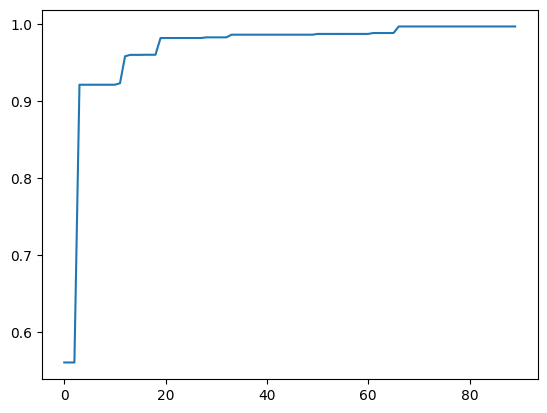

In [8]:
ax_client = optimizer.ax_client
pareto = ax_client.get_pareto_optimal_parameters(use_model_predictions=False)
best_keys = list(pareto.keys())
print(pareto)
plt.figure()
plt.plot(ax_client.get_trace())

#find max in get_trace
max_val = np.max(ax_client.get_trace())
index_max = np.argmax(ax_client.get_trace())
index_max = best_keys[0]
best_parameters = pareto[index_max][0]

RateEq.params_w(best_parameters,RateEq.params)


In [9]:
# plot the evolution of the optimization
render(ax_client.get_contour_plot(param_x="k_direct", param_y="k_trap", metric_name=optimizer.all_metrics[0]))

model = ax_client.generation_strategy.model

render(plot_slice(model=model, param_name="k_direct", metric_name=optimizer.all_metrics[0]))


[INFO 12-10 16:22:46] ax.service.ax_client: Retrieving contour plot with parameter 'k_direct' on X-axis and 'k_trap' on Y-axis, for metric 'RateEq_trPL_mse'. Remaining parameters are affixed to the middle of their range.


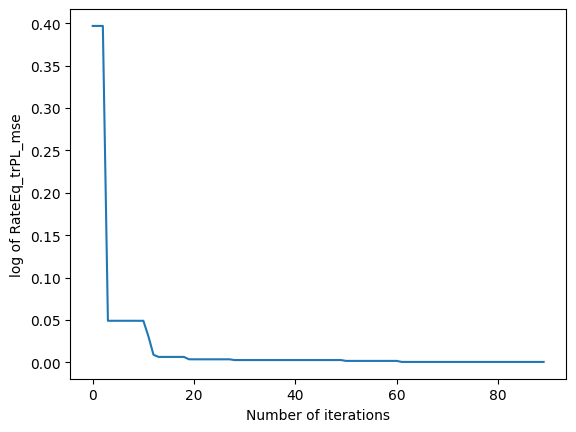

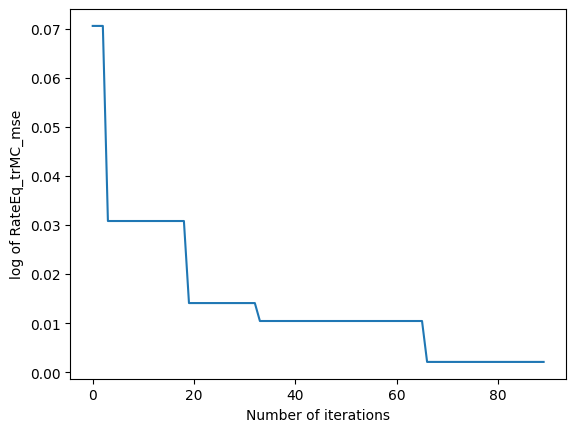

In [12]:
data = ax_client.experiment.fetch_data()
# split df by metric name 
data = data.df
metric1_df = data[data["metric_name"] == optimizer.all_metrics[0]]
metric2_df = data[data["metric_name"] == optimizer.all_metrics[1]]

# reset index
metric1_df = metric1_df.reset_index(drop=True)
metric2_df = metric2_df.reset_index(drop=True)

# plt.figure()
# plt.plot(np.minimum.accumulate(data.df["mean"]), label="Best value seen so far")

plt.figure()
plt.plot(np.minimum.accumulate(metric1_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[0])

plt.figure()
plt.plot(np.minimum.accumulate(metric2_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[1])

plt.show()


In [14]:
# create dic with keys same as ax_client.experiment.trials[0].arm.parameters
dumdic = {}
for key in ax_client.experiment.trials[0].arm.parameters.keys():
    dumdic[key] = []

# fill the dic with the values of the parameters
for i in range(len(ax_client.experiment.trials)):
    if ax_client.experiment.trials[i].status == T.COMPLETED:
        for key in ax_client.experiment.trials[i].arm.parameters.keys():
            dumdic[key].append(ax_client.experiment.trials[i].arm.parameters[key])


data = ax_client.experiment.fetch_data().df

target1 = data[data['metric_name'] == optimizer.all_metrics[0]]['mean']

dumdic[optimizer.all_metrics[0]] = list(target1)

target2 = data[data['metric_name'] ==  optimizer.all_metrics[1]]['mean']

dumdic[optimizer.all_metrics[1]] = list(target2)

dumdic['iteration'] = list(data[data['metric_name'] == optimizer.all_metrics[0]]['trial_index'])

df = pd.DataFrame(dumdic)


for par in params:
    if par.name in df.columns:
        if par.rescale:
            df[par.name] = df[par.name] * par.fscale


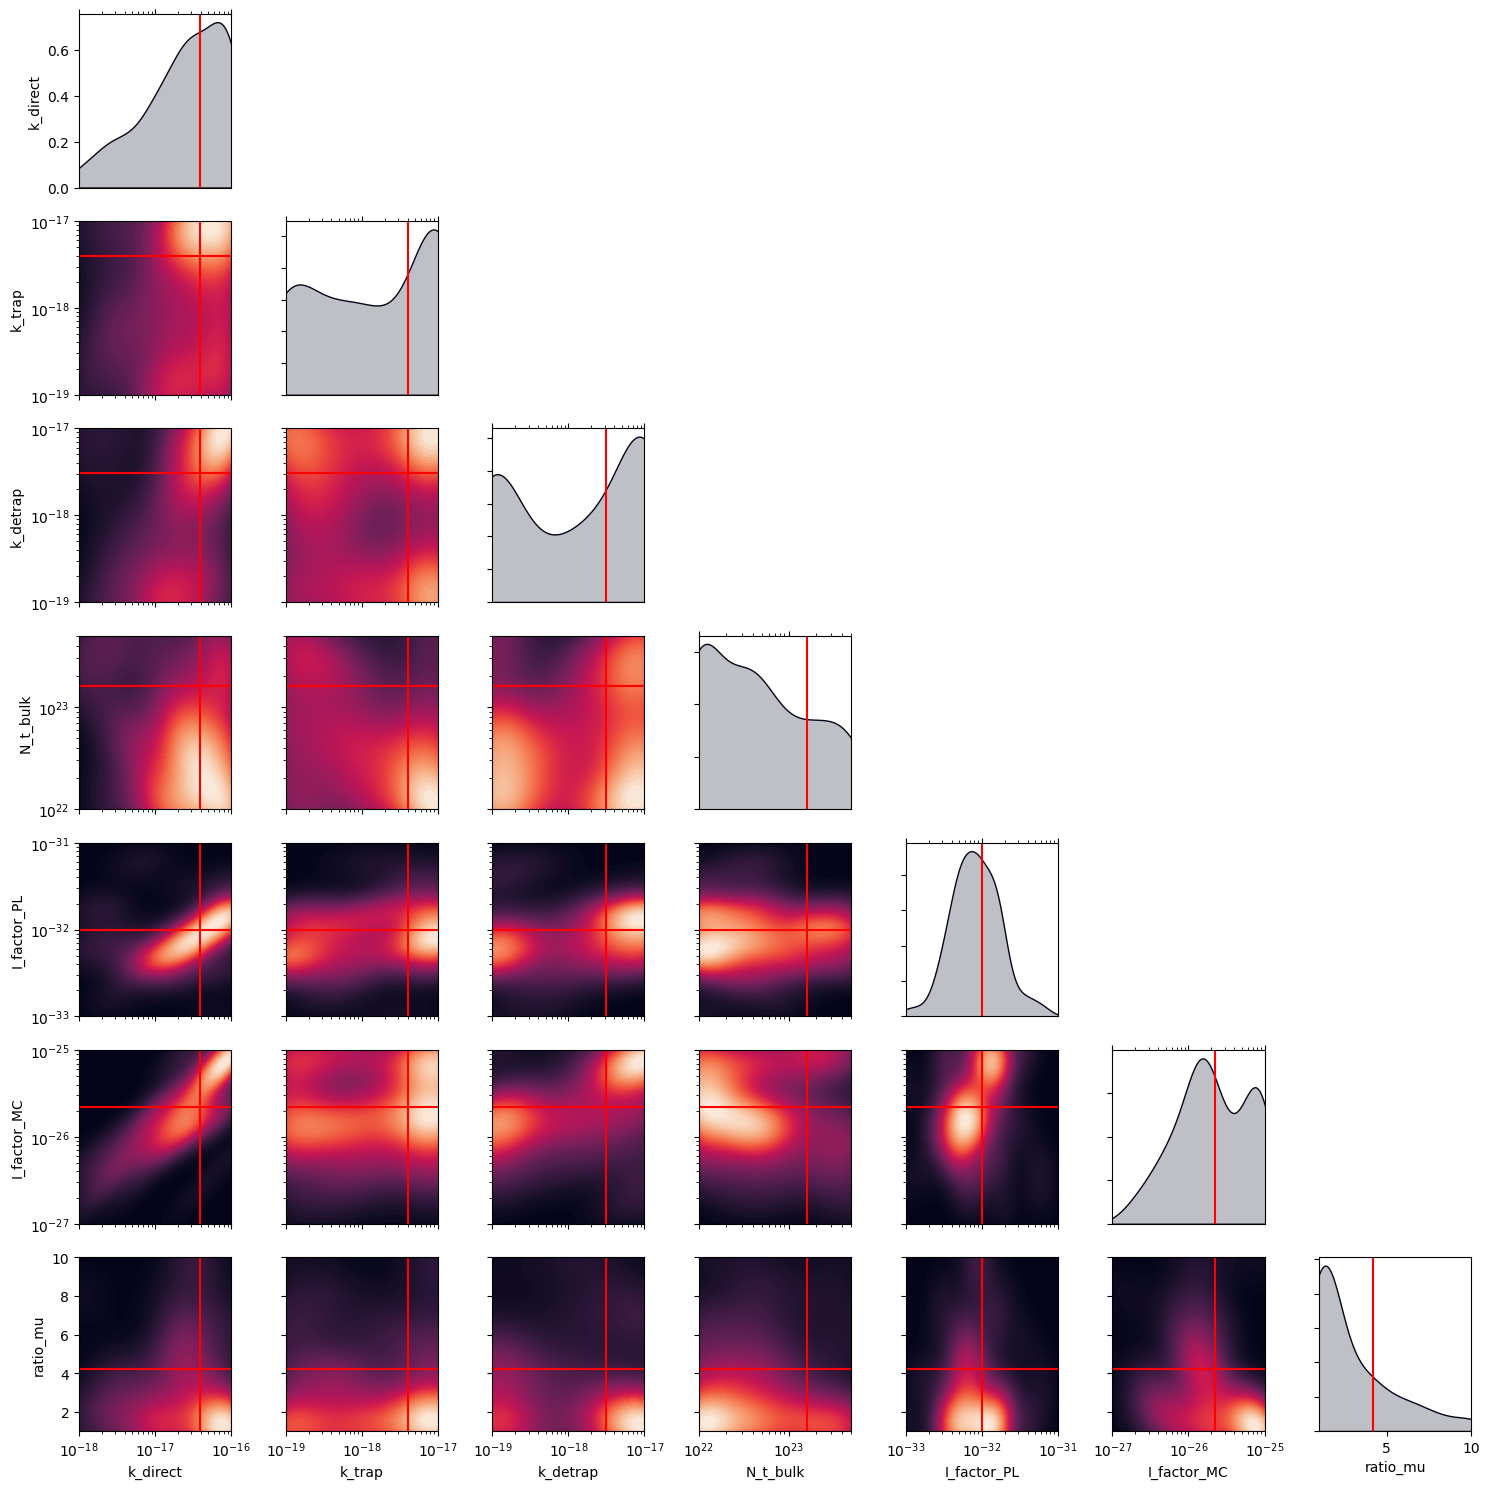

In [15]:
# get name of all parameters that are not 'fixed'
names = []
log_scale = []
axis_limits = []
for p in params:
    if p.type != 'fixed':
        names.append(p.name)
        log_scale.append(p.axis_type == 'log')
        axis_limits.append(p.bounds)


# Get all combinations of names
comb = list(combinations(names, 2))

# Determine the grid size
n = len(names)
fig, axes = plt.subplots(n, n, figsize=(15, 15))

# Plot each combination in the grid
for i, xx in enumerate(names):
    for j, yy in enumerate(names):
        xval = np.nan
        yval = np.nan

        for p in params_orig:
            if p.name == xx:
                xval = p.value
            if p.name == yy:
                yval = p.value

        ax = axes[i, j]
        if i == j:
            # kde plot on the diagonal
            sns.kdeplot(x=yy, data=df, ax=ax, fill=True, thresh=0, levels=100, cmap="rocket", color="#03051A", log_scale=log_scale[names.index(xx)])

            ax.axvline(x=yval, color='r', linestyle='-')
            # put point at the best value top of the axis
           

            if log_scale[names.index(yy)]:
                ax.set_xscale('log')
                ax.set_xlim(axis_limits[names.index(yy)])
            else:
                ax.set_xlim(axis_limits[names.index(yy)])
            
            # put x label on the top
            # except for the last one
            if i < n - 1:
                ax.xaxis.set_label_position('top')
                ax.xaxis.tick_top()

        elif i > j:
            kind = 'kde'
            if kind == 'scatter':
                sns.scatterplot(x=yy, y=xx, data=df, ax=ax, color="#03051A")
                ax.set_xscale('log')
                ax.set_yscale('log')
            else:
                sns.kdeplot(x=yy, y=xx, data=df, ax=ax, fill=True, thresh=0, levels=100, cmap="rocket", color="#03051A", log_scale=(log_scale[names.index(yy)], log_scale[names.index(xx)]))

            xval = np.nan
            yval = np.nan
            for p in params_orig:
                if p.name == xx:
                    xval = p.value
                elif p.name == yy:
                    yval = p.value

            # Plot as line over the full axis
            ax.axhline(y=xval, color='r', linestyle='-')
            ax.axvline(x=yval, color='r', linestyle='-')
            ax.scatter(best_parameters[yy], best_parameters[xx], c='y', marker='*', s=200, zorder=10)
            
            ax.set_xlim(axis_limits[names.index(yy)])
            ax.set_ylim(axis_limits[names.index(xx)])
        else:
            ax.set_visible(False)

        if j > 0:
            ax.set_yticklabels([])
            # remove the y axis label
            ax.set_ylabel('')
        if i < n - 1:
            ax.set_xticklabels([])
            # remove the x axis label
            ax.set_xlabel('')

        if i == n - 1:
            ax.set_xlabel(yy)
        if j == 0:
            ax.set_ylabel(xx)

plt.tight_layout()
plt.show()


Text(0, 0.5, 'trPL [a.u.]')

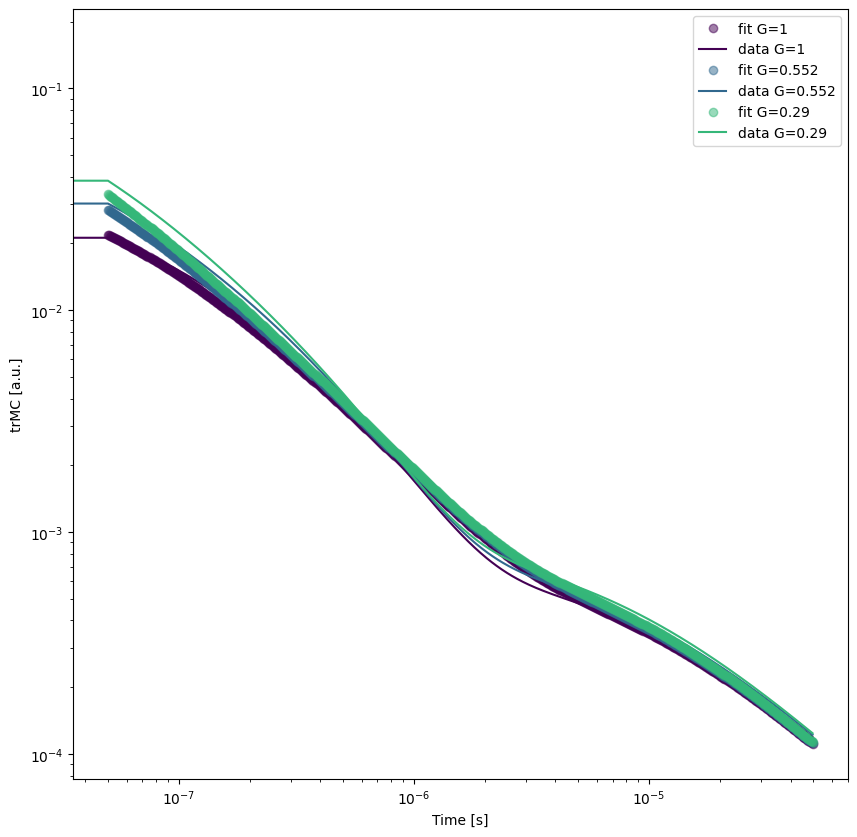

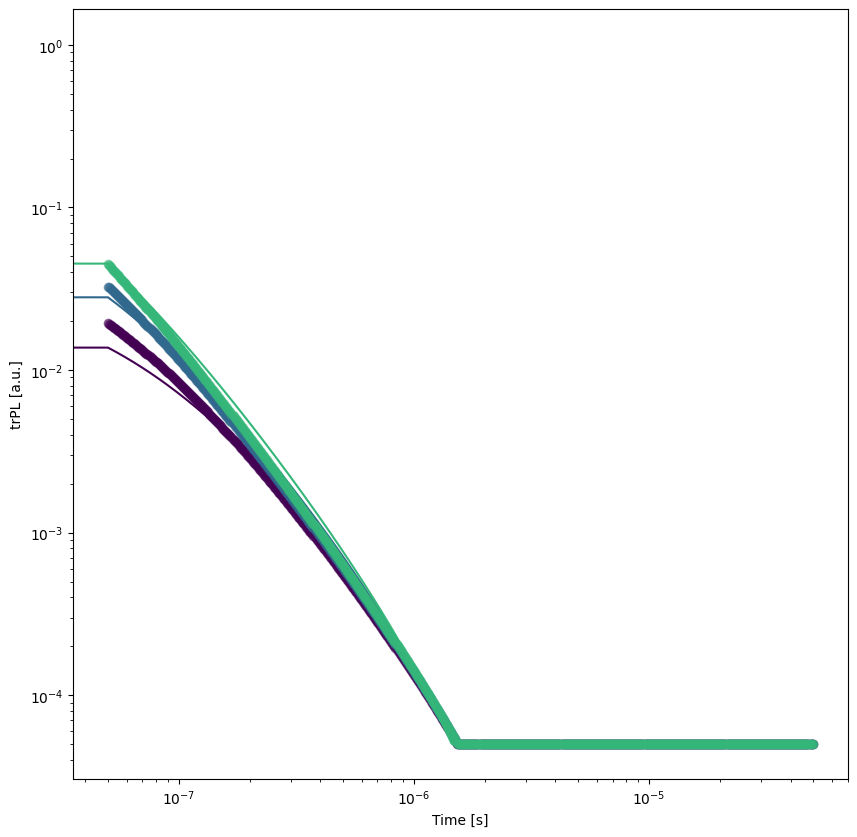

In [18]:
# rerun the simulation with the best parameters
y_fit_MC = RateEq.run(parameters=best_parameters,exp_format='trMC')

plt.figure(figsize=(10,10))

viridis = plt.cm.get_cmap('viridis', 4)
for idx, Gfrac in enumerate(Gfracs):
    plt.plot(X[X[:,1]==Gfrac,0], y_fit_MC[X[:,1]==Gfrac],'o',label='fit G='+str(Gfrac),alpha=0.5,color=viridis(idx))
    plt.plot(X[X[:,1]==Gfrac,0], y_MC[X[:,1]==Gfrac],'-',label='data G='+str(Gfrac),color=viridis(idx))
    
# plt.plot(X[:,0],y,'o',label='data')
# plt.plot(X[:,0],yfit,'o',label='fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('trMC [a.u.]')
plt.legend()


y_fit_PL = RateEq.run(parameters=best_parameters,exp_format='trPL')

plt.figure(figsize=(10,10))

viridis = plt.cm.get_cmap('viridis', 4)
for idx, Gfrac in enumerate(Gfracs):
    plt.plot(X[X[:,1]==Gfrac,0], y_fit_PL[X[:,1]==Gfrac],'o',label='fit G='+str(Gfrac),alpha=0.5,color=viridis(idx))
    plt.plot(X[X[:,1]==Gfrac,0], y_PL[X[:,1]==Gfrac],'-',label='data G='+str(Gfrac),color=viridis(idx))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('trPL [a.u.]')